# Version 3: with the help of Claude code to find the state of the art solution.


## 0. IMPORTS


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from pathlib import Path
import cv2
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from monai.losses import DiceCELoss, FocalLoss, TverskyLoss
from monai.metrics import DiceMetric, HausdorffDistanceMetric

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading and Preprocessing

This project uses a custom `BrainTumorDataset` class, built on `torch.utils.data.Dataset`, to efficiently load and preprocess the brain MRI data.

Key features of the data pipeline:

- **File Handling:** It automatically discovers image-mask pairs from separate directories, ensuring that only images with corresponding masks are used for training.
- **Preprocessing:**
  - Images are loaded and converted to a standard format (RGB or grayscale).
  - Both images and masks are resized to a uniform dimension (`512x512`) to be compatible with the model input. It correctly uses `INTER_NEAREST` interpolation for masks to preserve sharp boundaries.
  - Masks are binarized (0 for background, 1 for tumor) to create a clear ground truth for segmentation.
- **Augmentation:** The dataset is designed to integrate seamlessly with data augmentation libraries like `albumentations`. It handles the conversion of grayscale images to a 3-channel format required by many standard augmentation transforms.
- **Tensor Conversion:** Final images and masks are converted into PyTorch tensors, with masks specifically cast to `long` type, making them ready for use with common loss functions like `CrossEntropyLoss` or `DiceLoss`.


In [31]:
class BrainTumorDataset(Dataset):
    """
    Custom PyTorch Dataset for brain tumor segmentation.
    Loads images and masks, applies transformations, and prepares them for the model.
    """
    def __init__(self, images_dir, masks_dir, transform=None, image_size=(512, 512)):
        # 1. Initialize paths and parameters
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.transform = transform
        self.image_size = image_size
        
        # 2. Get all image files from the directory
        self.image_files = sorted( list(self.images_dir.glob("*.png")) )
        
        # 3. Filter files to ensure each image has a corresponding mask
        self.valid_files = []
        for img_path in self.image_files:
            mask_path = self.masks_dir / img_path.name
            if mask_path.exists():
                self.valid_files.append(img_path)
        
        print(f"Found {len(self.valid_files)} valid image-mask pairs")
        
    def __len__(self):
        # Return the total number of valid samples
        return len(self.valid_files)
    
    def __getitem__(self, idx):
        # --- 1. Load files ---
        img_path = self.valid_files[idx]
        mask_path = self.masks_dir / img_path.name
        
        # --- 2. Read image and mask ---
        # Read image and convert from BGR (OpenCV default) to RGB
        image = cv2.imread(str(img_path))
        if image is None:
            raise ValueError(f"Could not load image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Read mask as a single-channel grayscale image
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Could not load mask: {mask_path}")
        
        # --- 3. Preprocessing ---
        # Resize image and mask to a consistent size
        if image.shape[:2] != self.image_size:
            # Use linear interpolation for the image
            image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_LINEAR)
            # Use nearest-neighbor interpolation for the mask to preserve binary values
            mask = cv2.resize(mask, self.image_size, interpolation=cv2.INTER_NEAREST)
        
        # Convert to grayscale if the image is 3-channel but has identical channels
        if len(image.shape) == 3 and image.shape[2] == 3:
            # Check if it's actually grayscale (all channels equal)
            if np.allclose(image[:,:,0], image[:,:,1]) and np.allclose(image[:,:,1], image[:,:,2]):
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Binarize the mask: pixels > 127 become 1 (tumor), others 0 (background)
        mask = (mask > 127).astype(np.uint8)
        
        # --- 4. Apply augmentations ---
        if self.transform:
            # Convert grayscale to 3-channel for compatibility with some albumentations transforms
            if len(image.shape) == 2:
                image = np.stack([image, image, image], axis=-1)
            
            # Apply the provided transformation pipeline
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # --- 5. Final conversion for PyTorch ---
        # Ensure mask is a torch.LongTensor with shape [1, H, W]
        import torch as _torch
        if not isinstance(mask, _torch.Tensor):
            # mask is numpy array [H, W]
            mask = _torch.from_numpy(mask)
        # If mask is 2D (H, W) -> add channel dim to become [1, H, W]
        if mask.dim() == 2:
            mask = mask.unsqueeze(0)
        # Ensure dtype long
        mask = mask.long()
        
        # Ensure image is a torch.FloatTensor with shape [C, H, W]
        if not isinstance(image, _torch.Tensor):
            # image is numpy H,W,C or H,W (grayscale)
            image = _torch.from_numpy(image)
            if image.ndim == 3:  # H, W, C -> C, H, W
                image = image.permute(2, 0, 1).float()
            elif image.ndim == 2:  # H, W -> add channel and replicate to 3 channels
                image = image.unsqueeze(0).repeat(3, 1, 1).float()
            # If values are 0-255 convert to 0-1
            if image.max() > 1.0:
                image = image / 255.0
        else:
            # If transform already produced a tensor, ensure channel dim ordering is C,H,W and dtype float
            if image.dim() == 3 and image.shape[0] in (1,3):  # likely already C,H,W
                image = image.float()
            elif image.dim() == 3 and image.shape[2] in (1,3):  # H,W,C -> convert
                image = image.permute(2,0,1).float()
            elif image.dim() == 2:
                image = image.unsqueeze(0).repeat(3,1,1).float()
		
        # Return a dictionary containing the processed data
        return {
            'image': image,
            'mask': mask,
            'filename': img_path.name
        }


## 2. Data Augmentation Strategy

To build a robust segmentation model, a comprehensive data augmentation strategy is employed using the `albumentations` library. Separate pipelines are defined for the training and validation datasets to ensure proper model training and unbiased evaluation.

**Training Augmentations (`get_train_transforms`)**

The training pipeline applies a wide variety of augmentations to teach the model to be invariant to changes in position, orientation, and imaging conditions. This helps prevent overfitting and improves generalization to unseen data. Key transformations include:

- **Geometric Transforms:** Random rotations, flips, transpositions, and a combined shift-scale-rotate transform to handle variations in patient positioning.
- **Elastic Deformations:** ElasticTransform and GridDistortion are used to simulate the non-rigid nature of biological tissue, a critical augmentation for medical imaging.
- **Intensity and Noise:** Adjustments to brightness, contrast, and gamma, along with the addition of Gaussian noise and blur, mimic differences between MRI scanners and acquisition protocols.
- **Contrast Enhancement:** CLAHE (Contrast Limited Adaptive Histogram Equalization) is applied to enhance local contrast, making subtle tumor boundaries more apparent.
- **Final Preprocessing:** Images are normalized using standard ImageNet statistics and converted to PyTorch tensors.

**Validation Preprocessing (`get_val_transforms`)**

The validation pipeline is minimal and deterministic. It contains **no random augmentations**. This is crucial for obtaining a stable and reliable measure of the model's performance. The only steps are:

1. **Normalization**: To ensure the validation data is in the same value range as the training data.
1. **Tensor Conversion**: To prepare the data for model input.

This dual-pipeline approach ensures the model learns from a diverse set of examples while being evaluated on a consistent, unaltered dataset.


In [32]:
def get_train_transforms():
    """
    Defines the augmentation pipeline for the training dataset.
    Uses a rich set of transforms to improve model robustness and generalization.
    """
    return A.Compose([
        # --- 1. Geometric Transformations ---
        # These alter the spatial orientation of the image.
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.0625,
            scale_limit=0.1,
            rotate_limit=15,
            border_mode=cv2.BORDER_CONSTANT, # Fill new pixels with a constant value
            value=0,
            mask_value=0,
            p=0.5
        ),

        # --- 2. Non-rigid (Elastic) Transformations ---
        # These simulate tissue deformation, which is common in medical scans.
        A.ElasticTransform(
            alpha=1,
            sigma=50,
            alpha_affine=50,
            border_mode=cv2.BORDER_CONSTANT,
            value=0,
            mask_value=0,
            p=0.3
        ),
        A.GridDistortion(
            num_steps=5,
            distort_limit=0.3,
            border_mode=cv2.BORDER_CONSTANT,
            value=0,
            mask_value=0,
            p=0.3
        ),

        # --- 3. Intensity and Color Transformations ---
        # These alter pixel values to simulate different lighting/scanner conditions.
        A.RandomBrightnessContrast(
            brightness_limit=0.2,
            contrast_limit=0.2,
            p=0.5
        ),
        A.RandomGamma(gamma_limit=(80, 120), p=0.3),

        # --- 4. Noise and Blurring ---
        # Simulates sensor noise and minor focus issues.
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        A.GaussianBlur(blur_limit=3, p=0.2),

        # --- 5. Advanced Contrast Enhancement ---
        # CLAHE is highly effective for enhancing local contrast in medical images.
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),

        # --- 6. Final Preprocessing Steps ---
        # Normalize the image using ImageNet stats (a common starting point).
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
        ),
        # Convert the image and mask to PyTorch Tensors.
        ToTensorV2(),
    ])


def get_val_transforms():
    """
    Defines the transformation pipeline for the validation dataset.
    Only includes essential preprocessing steps, no random augmentations.
    """
    return A.Compose([
        # 1. Normalize the image to match the training data distribution.
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
        ),
        # 2. Convert the image and mask to PyTorch Tensors.
        ToTensorV2(),
    ])


train_trans = get_train_transforms()
val_trans = get_val_transforms()

train_trans, val_trans

(Compose([
   RandomRotate90(p=0.5),
   HorizontalFlip(p=0.5),
   VerticalFlip(p=0.5),
   Transpose(p=0.5),
   ShiftScaleRotate(p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-15.0, 15.0), interpolation=1, border_mode=0, fill=0.0, fill_mask=0.0, rotate_method='largest_box', mask_interpolation=0),
   ElasticTransform(p=0.3, alpha=1.0, approximate=False, border_mode=0, fill=0.0, fill_mask=0.0, interpolation=1, keypoint_remapping_method='mask', mask_interpolation=0, noise_distribution='gaussian', same_dxdy=False, sigma=50.0),
   GridDistortion(p=0.3, border_mode=0, distort_limit=(-0.3, 0.3), fill=0.0, fill_mask=0.0, interpolation=1, keypoint_remapping_method='mask', mask_interpolation=0, normalized=True, num_steps=5),
   RandomBrightnessContrast(p=0.5, brightness_by_max=True, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), ensure_safe_range=False),
   RandomGamma(p=0.3, gamma_limit=(

## 3. Model Architecture

The model uses a **UNet++** architecture with a pretrained `EfficientNet-B4` encoder, leveraging transfer learning for faster convergence and better performance. To further boost training, it incorporates **deep supervision**, which applies auxiliary loss signals to intermediate layers. During inference, only the final, full-resolution prediction is used to generate the segmentation map.


In [33]:
from torchinfo import summary

class BrainTumorSegmentationModel(nn.Module):
    """
    A segmentation model using a UNet++ decoder with a pretrained EfficientNet encoder.
    Implements deep supervision for improved training performance.
    """
    def __init__(self, num_classes=2, encoder_name="efficientnet-b4"):
        super().__init__()
        
        # 1. Initialize the main model from the segmentation-models-pytorch (smp) library.
        # UNet++ often provides better performance than standard U-Net due to its nested skip pathways.
        self.model = smp.UnetPlusPlus(
            encoder_name=encoder_name,      # The backbone network (e.g., 'efficientnet-b4').
            encoder_weights="imagenet",     # Use pretrained weights for transfer learning.
            in_channels=3,                  # Expects 3-channel (RGB) input images.
            classes=num_classes,            # Number of output classes (e.g., 2 for background/tumor).
            activation=None,                # Output raw logits; activation is handled by the loss function.
        )
        
        # Get the number of output channels from each stage of the encoder.
        # This makes the model adaptable to different encoder backbones.
        encoder_channels = self.model.encoder.out_channels
        
        # 2. Define auxiliary heads for deep supervision.
        # This technique adds loss signals at intermediate decoder layers to improve gradient flow.
        self.deep_supervision = True
        if self.deep_supervision:
            # These heads are simple 1x1 convolutions that map intermediate feature maps
            # from the decoder to the desired number of output classes.
            self.aux_head1 = nn.Conv2d(encoder_channels[-2], num_classes, kernel_size=1)
            self.aux_head2 = nn.Conv2d(encoder_channels[-3], num_classes, kernel_size=1)
    
    def forward(self, x):
        # --- Main Forward Pass ---
        main_output = self.model(x)
        
        # --- Deep Supervision (only during training) ---
        if self.training and self.deep_supervision:
            # Get the feature maps from different stages of the encoder.
            # Note: This is a simplified implementation; it re-runs the encoder.
            features = self.model.encoder(x)
            
            # Create auxiliary predictions from intermediate feature maps.
            # These features correspond to different spatial scales in the network.
            aux1 = self.aux_head1(features[-2])  # Feature map at 1/16 resolution
            aux2 = self.aux_head2(features[-3])  # Feature map at 1/8 resolution
            
            # Upsample the auxiliary predictions to match the main output's spatial dimensions.
            aux1 = F.interpolate(aux1, size=main_output.shape[2:], mode='bilinear', align_corners=False)
            aux2 = F.interpolate(aux2, size=main_output.shape[2:], mode='bilinear', align_corners=False)
            
            # Return a dictionary of outputs. The loss function will handle combining them.
            return {
                'main': main_output,
                'aux1': aux1,
                'aux2': aux2
            }
        
        # During validation or inference, only return the final, main prediction.
        return main_output

model = BrainTumorSegmentationModel()
summary(model, input_size=(1, 3, 512, 512))


Layer (type:depth-idx)                                       Output Shape              Param #
BrainTumorSegmentationModel                                  [1, 2, 512, 512]          436
├─UnetPlusPlus: 1-1                                          [1, 2, 512, 512]          --
│    └─EfficientNetEncoder: 2-1                              [1, 3, 512, 512]          806,400
│    │    └─Conv2dStaticSamePadding: 3-1                     [1, 48, 256, 256]         1,296
│    │    └─BatchNorm2d: 3-2                                 [1, 48, 256, 256]         96
│    │    └─SiLU: 3-3                                        [1, 48, 256, 256]         --
│    │    └─ModuleList: 3-4                                  --                        16,740,824
│    └─UnetPlusPlusDecoder: 2-2                              [1, 16, 512, 512]         --
│    │    └─ModuleDict: 3-5                                  --                        3,264,352
│    └─SegmentationHead: 2-3                                 [1, 2, 512

## 4. ADVANCED Loss Function

To effectively train the segmentation model, a sophisticated `CombinedLoss` function is implemented. A single loss function is often insufficient for complex medical imaging tasks, so this approach combines the strengths of three different state-of-the-art loss functions from the MONAI library:

1. `DiceCELoss`: A powerful hybrid loss that combines the region-based **Dice Loss** (excellent for handling class imbalance) with the pixel-wise **Cross-Entropy Loss** (ensures good per-pixel classification). This forms the primary component of our total loss.

2. `FocalLoss`: This loss modifies Cross-Entropy to down-weight the loss assigned to well-classified examples. This forces the model to focus its efforts on **hard-to-classify pixels**, such as those along the ambiguous boundaries of a tumor.

3. `TverskyLoss`: A generalization of the Dice score that provides a trade-off between **false positives** and **false negatives**. In our configuration, it is tuned to penalize false positives more heavily, which can help reduce the prediction of non-tumor areas.

These three losses are combined in a weighted sum. Furthermore, the `CombinedLoss` class is designed to seamlessly handle the **deep supervision** outputs from the model, applying a weighted loss to the main and auxiliary predictions to ensure robust gradient flow throughout the network during training.


In [34]:
class CombinedLoss(nn.Module):
    """
    A custom loss function that combines multiple state-of-the-art segmentation losses.
    Designed to handle class imbalance and focus on difficult examples.
    """
    def __init__(self, alpha=0.5, beta=0.3, gamma=0.2):
        super().__init__()
        # 1. Define weights for combining the individual loss components.
        self.alpha = alpha  # Weight for Dice+CE loss
        self.beta = beta    # Weight for Focal loss
        self.gamma = gamma  # Weight for Tversky loss
        
        # 2. Initialize the individual loss functions from the MONAI library.
        # Dice + CrossEntropy: A robust combination for general segmentation tasks.
        self.dice_ce = DiceCELoss(
            include_background=False, # Exclude background class from Dice calculation.
            to_onehot_y=True,         # Convert target to one-hot format.
            softmax=True,             # Apply softmax to predictions.
            lambda_dice=0.5,          # Weight for Dice component.
            lambda_ce=0.5,            # Weight for CrossEntropy component.
            squared_pred=True,        # Use squared predictions in Dice denominator for smoother gradients.
            smooth_nr=1e-5,
            smooth_dr=1e-5
        )
        
        # Focal Loss: Helps focus training on hard-to-classify pixels (e.g., boundaries).
        self.focal = FocalLoss(
            include_background=False,
            to_onehot_y=True,
            alpha=0.75,
            gamma=2.0,                # Focusing parameter.
            reduction='mean'          # Average the loss over the batch.
        )
        
        # Tversky Loss: A generalization of Dice that allows weighting false positives and negatives.
        self.tversky = TverskyLoss(
            include_background=False,
            to_onehot_y=True,
            softmax=True,
            alpha=0.7,  # Penalizes false positives more heavily.
            beta=0.3,   # Penalizes false negatives less heavily.
            smooth_nr=1e-5,
            smooth_dr=1e-5
        )
    
    def forward(self, pred, target):
        # This method handles both standard and deep supervision model outputs.
        
        if isinstance(pred, dict):
            # --- Handle Deep Supervision ---
            # If the prediction is a dictionary, it contains outputs from multiple model heads.
            main_loss = self._compute_loss(pred['main'], target)
            aux1_loss = self._compute_loss(pred['aux1'], target)
            aux2_loss = self._compute_loss(pred['aux2'], target)
            
            # Combine the losses, giving less weight to the auxiliary outputs.
            total_loss = main_loss + 0.4 * aux1_loss + 0.2 * aux2_loss
            return total_loss
        
        else:
            # --- Handle Standard Output ---
            # If the prediction is a single tensor, compute the loss directly.
            return self._compute_loss(pred, target)
    
    def _compute_loss(self, pred, target):
        # Helper method to calculate the weighted sum of the three loss components.
        dice_ce_loss = self.dice_ce(pred, target)
        focal_loss = self.focal(pred, target)
        tversky_loss = self.tversky(pred, target)
        
        # Combine the individual losses using the predefined alpha, beta, and gamma weights.
        return  (self.alpha * dice_ce_loss + 
                   self.beta * focal_loss + 
                   self.gamma * tversky_loss)



## 5. Training UTILITIES

The training process is configured using a set of modular helper functions:

- `create_dataloaders`: Prepares the data by splitting it into training and validation sets, applying the correct data augmentations to each, and creating `DataLoader` instances for model consumption.
- `setup_training`: Configures the `AdamW` optimizer and the `OneCycleLR` learning rate scheduler, which are modern, high-performance choices for training deep learning models.
- `setup_metrics`: Initializes the key performance indicators for evaluation, including the `DiceMetric` (to measure segmentation overlap) and the `HausdorffDistanceMetric` (to measure boundary accuracy).


In [35]:
import random
import numpy as np
import torch

def set_seeds(seed: int = 42):
    """
    Sets the random seeds for Python, NumPy, and PyTorch to ensure reproducibility.
    
    Args:
        seed (int): The seed value to use.
    """
    # Set the seed for Python's built-in random module
    random.seed(seed)
    
    # Set the seed for NumPy
    np.random.seed(seed)
    
    # Set the seed for PyTorch
    torch.manual_seed(seed)
    
    # If you are using a GPU, also set the seed for CUDA
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        
        # The following two lines are often used to ensure reproducibility on CUDA,
        # but they can negatively impact performance.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [36]:
from torch.utils.data import DataLoader, Subset
import numpy as np

def create_dataloaders(images_dir, masks_dir, batch_size=8, num_workers=0, 
                        train_split=0.8, image_size=(512, 512), random_seed=42):
    """
    Create train and validation dataloaders efficiently using PyTorch Subsets.
    """
    
    # 1. Create two dataset instances, one for training and one for validation. 
    # This still scans the directory twice but is necessary to assign different transforms.
    train_dataset = BrainTumorDataset(
        images_dir=images_dir,
        masks_dir=masks_dir,
        transform=get_train_transforms(),
        image_size=image_size
    )
    
    val_dataset = BrainTumorDataset(
        images_dir=images_dir,
        masks_dir=masks_dir,
        transform=get_val_transforms(),
        image_size=image_size
    )
    
    # 2. Create a random split of indices.
    set_seeds(random_seed)
    dataset_size = len(train_dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(train_split * dataset_size))
    np.random.shuffle(indices)
    train_indices, val_indices = indices[:split], indices[split:]

    # 3. Create PyTorch subsets with the split indices.
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(val_dataset, val_indices)

    # 4. Create dataloaders from the subsets.
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    print(f"Train dataset size: {len(train_subset)}")
    print(f"Validation dataset size: {len(val_subset)}")
    
    return train_loader, val_loader

In [37]:
def setup_training(model, train_loader, epochs=100, max_lr=3e-4):
    """
    Configures the optimizer and learning rate scheduler for model training.
    """
    # 1. Initialize the AdamW optimizer.
    # AdamW is an improved version of Adam that decouples weight decay from the gradient update,
    # which often leads to better model generalization.
    optimizer = AdamW(
        model.parameters(),
        lr=max_lr,           # The maximum learning rate.
        weight_decay=1e-4,   # Regularization term to prevent overfitting.
        betas=(0.9, 0.999),  # Coefficients for computing running averages of gradient and its square.
        eps=1e-8
)
    
    # 2. Initialize the OneCycleLR scheduler.
    # This scheduler varies the learning rate cyclically, starting low, increasing to a
    # maximum, and then decreasing. It's known to help models converge faster and avoid
    # getting stuck in local minima.
    scheduler = OneCycleLR(
        optimizer,
        max_lr=max_lr,                      # The upper learning rate boundary.
        epochs=epochs,                      # Total number of epochs for the cycle.
        steps_per_epoch=len(train_loader),  # Number of batches in one epoch.
        pct_start=0.3,                      # Percentage of the cycle spent increasing the LR.
        div_factor=25,                      # Determines the initial LR (max_lr / div_factor).
        final_div_factor=1e4,               # Determines the minimum LR (initial_lr / final_div_factor).
        anneal_strategy='cos'               # Use a cosine annealing strategy for the decay phase.
    )
    
    return optimizer, scheduler

In [38]:
def setup_metrics():
    """
    Initializes a dictionary of metrics for evaluating segmentation performance.
    """
    metrics = {
        # 1. Dice Metric: Measures the overlap between prediction and ground truth.
        # It is the primary metric for most segmentation tasks.
        'dice': DiceMetric(
            include_background=False, # Crucial: only evaluate the tumor class, not the background.
            reduction="mean",         # Average the score across all images in a batch.
            get_not_nans=False
        ),
        
        # 2. Hausdorff Distance: Measures the distance between the boundaries of the
        # predicted and ground truth segmentations. Excellent for evaluating boundary accuracy.
        'hausdorff': HausdorffDistanceMetric(
            include_background=False, # Also focus only on the tumor class.
            reduction="mean",         # Average the score across the batch.
            percentile=95             # Use the 95th percentile to make the metric robust to outliers.
        )
    }
    return metrics

## 6. Training and Validation loops

The training and validation loops are managed by two core functions:

- `train_epoch`: Executes a single training epoch, performing forward and backward passes, calculating loss, updating model weights with `AdamW`, adjusting the learning rate via `OneCycleLR`, and utilizing Automatic Mixed Precision (AMP) for efficiency.
- `validate_epoch`: Runs a single validation epoch, computing the loss and evaluating the model's performance using `DiceMetric` and `HausdorffDistanceMetric` without updating model parameters.


In [50]:
def train_epoch(model, train_loader, optimizer, scheduler, loss_fn, scaler, device):
    """
    Performs one full training epoch.
    """
    # 1. Set model to training mode.
    model.train()
    
    # 2. Initialize total loss for the epoch.
    total_loss = 0 
    
    # 3. Setup progress bar.
    pbar = tqdm(train_loader, desc="Training") 
    
    for batch_idx, batch in enumerate(pbar):
        # 4. Move batch data to the specified device.
        images = batch['image'].to(device, non_blocking=True) 
        # Keep mask channel dimension: expect label map [B, 1, H, W] for MONAI losses that accept B1HW format
        masks = batch['mask'].long().to(device, non_blocking=True)  # [B, 1, H, W]
        
        # 5. Clear previous gradients.
        optimizer.zero_grad() 
        
        # 6. Enable Automatic Mixed Precision (AMP) for efficiency.
        with torch.amp.autocast(device_type= device):
            # 7. Forward pass.
            outputs = model(images) 
            # Loss implementations (MONAI) expect target shape matching B1H[WD] when not already one-hot.
            
            loss = loss_fn(outputs, masks)             
            
        # 9. Scale loss and perform backward pass.
        scaler.scale(loss).backward()
        # 10. Update model weights.
        scaler.step(optimizer) 
        # 11. Update the gradient scaler.
        scaler.update() 
        
        # 12. Update learning rate based on scheduler.
        scheduler.step() 
        
        # 13. Accumulate batch loss.
        total_loss += loss.item() 
        
        # 14. Update progress bar with current loss and learning rate.
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'LR': f'{scheduler.get_last_lr()[0]:.6f}'
        })
    
    # 15. Return average epoch loss.
    return total_loss / len(train_loader) 


def validate_epoch(model, val_loader, loss_fn, metrics, device):
    """
    Performs one full validation epoch.
    """
    # 1. Set model to evaluation mode.
    model.eval() 
    
    # 2. Initialize total loss for the epoch.
    total_loss = 0 
    
    # 3. Reset all evaluation metrics.
    for metric in metrics.values():
        metric.reset()
    
    # 4. Disable gradient calculations for validation.
    with torch.inference_mode(): 
        # 5. Setup progress bar.
        pbar = tqdm(val_loader, desc="Validation") 
        
        for batch in pbar:
            # 6. Move batch data to the specified device.
            images = batch['image'].to(device, non_blocking=True) 
            # Keep mask channel dimension: labels should be [B, 1, H, W] integers for MONAI losses
            masks = batch['mask'].long().to(device, non_blocking=True)  # [B, 1, H, W]
            
            # 7. Enable AMP for validation (no effect on gradients).
            with torch.amp.autocast(device_type= device): 
                # 8. Forward pass.
                outputs = model(images) 
                
                loss = loss_fn(outputs, masks)
                
            # 10. Accumulate batch loss.
            total_loss += loss.item() 
            
            # 11. Extract main output if deep supervision is used.
            if isinstance(outputs, dict):
                outputs = outputs['main']
            
            # 12. Prepare predictions and labels for metrics.
            # Convert logits to class labels (discrete) for Dice computation.
            # Use argmax on logits (or softmax) to get predicted class indices [B, H, W].
            pred_labels = torch.argmax(outputs, dim=1)  # [B, H, W]
            
            # Prepare one-hot predictions [B, C, H, W] for DiceMetric
            num_classes = outputs.shape[1]
            pred_onehot = F.one_hot(pred_labels, num_classes=num_classes)            # [B, H, W, C]
            pred_onehot = pred_onehot.permute(0, 3, 1, 2).to(outputs.dtype)          # [B, C, H, W]
            
            # Prepare one-hot labels [B, C, H, W] for DiceMetric
            labels_for_onehot = masks.squeeze(1).long()  # [B, H, W]
            labels_onehot = F.one_hot(labels_for_onehot, num_classes=num_classes)    # [B, H, W, C]
            labels_onehot = labels_onehot.permute(0, 3, 1, 2).to(outputs.dtype)      # [B, C, H, W]
            
            # 13. Update Dice metric with discrete one-hot predictions.
            metrics['dice'](pred_onehot, labels_onehot) 
            
            # 14. Prepare binary predictions and masks for Hausdorff distance.
            binary_preds = pred_labels.unsqueeze(1).long()  # [B,1,H,W]
            binary_masks = masks.long()                     # [B,1,H,W]
            
            # 15. Update Hausdorff metric.
            metrics['hausdorff'](binary_preds, binary_masks) 
    
    
    # 16. Aggregate and retrieve final metric scores.
    dice_score = metrics['dice'].aggregate().item() 
    hausdorff_dist = metrics['hausdorff'].aggregate().item() 
    
    # 17. Return average epoch loss and aggregated metrics.
    return total_loss / len(val_loader), dice_score, hausdorff_dist

## 7. MAIN TRAINING FUNCTION


In [48]:
import os

def train_model(images_dir, masks_dir, epochs=10, batch_size=8, image_size=(512, 512), load_model = False):
    """
    Orchestrates the entire training process for the brain tumor segmentation model.
    """
    # 1. Determine the device (GPU or CPU) for training.
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}") 
    
    # Create checkpoint directory
    checkpoint_dir = 'checkpoints_3'
    os.makedirs(checkpoint_dir, exist_ok=True)
    print(f"Checkpoints will be saved in '{checkpoint_dir}/'\n")

    
    # 2. Create data loaders for training and validation sets.
    train_loader, val_loader = create_dataloaders(images_dir=images_dir,
                                                masks_dir=masks_dir,
                                                batch_size=batch_size,
                                                image_size=image_size )
    
    # 3. Initialize the segmentation model and move it to the device.
    model = BrainTumorSegmentationModel(num_classes=2, 
                                        encoder_name="efficientnet-b4")
    model = model.to(device) 
    
    if load_model:
        try:
            checkpoint = torch.load("checkpoints_3/best_model.pth", map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Successfully loaded model from checkpoints_3/best_model.pth")
            
        except FileNotFoundError:
            print(f"Warning: Checkpoint 'checkpoints_3/best_model.pth' not found. Starting training from scratch.")
    
    # 4. Count and print model parameters for verification.
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # 5. Initialize loss function, optimizer, learning rate scheduler, metrics, and AMP scaler.
    loss_fn = CombinedLoss() 
    optimizer, scheduler = setup_training(model, train_loader, epochs) 
    metrics = setup_metrics() 
    scaler = torch.amp.GradScaler(device=device) 
    
    # 6. Initialize variables for tracking training progress.
    best_dice = 0.0 
    train_losses = [] 
    val_losses = [] 
    dice_scores = [] 
    
    # 7. Main training loop.
    for epoch in range(epochs): 
        print(f"\nEpoch {epoch+1}/{epochs}") 
        print("-" * 50) 
        
        # 8. Execute one training epoch.
        train_loss = train_epoch(model, train_loader, optimizer, scheduler, 
                                loss_fn, scaler, device)
        
        # 9. Execute one validation epoch.
        val_loss, dice_score, hausdorff_dist = validate_epoch(
            model, val_loader, loss_fn, metrics, device)
        
        # 10. Store epoch results.
        train_losses.append(train_loss) 
        val_losses.append(val_loss) 
        dice_scores.append(dice_score) 
        
        # 11. Print current epoch's performance.
        print(f"Train Loss: {train_loss:.4f}") 
        print(f"Val Loss: {val_loss:.4f}") 
        print(f"Dice Score: {dice_score:.4f}") 
        print(f"Hausdorff Distance: {hausdorff_dist:.4f}") 
        
        # Create a checkpoint dictionary to save
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'dice_score': dice_score,
            'val_loss': val_loss
        }

        # Save the model from the current epoch
        epoch_save_path = os.path.join(checkpoint_dir, f"epoch_{epoch+1}.pth")
        torch.save(checkpoint, epoch_save_path)
        
        # 12. Check if current Dice score is the best so far.
        if dice_score > best_dice:
            # 13. Update best Dice score.
            best_dice = dice_score 
            
            # 14. Save the best model checkpoint
            best_model_path = os.path.join(checkpoint_dir, "best_model.pth")
            torch.save(checkpoint, best_model_path) 
            print(f"New best model saved! Dice: {dice_score:.4f} at {best_model_path}") 
    
    # 15. Final training summary.
    print(f"\nTraining completed! Best Dice Score: {best_dice:.4f}")
    
    # 16. Load the best model weights before returning
    best_model_path = os.path.join(checkpoint_dir, "best_model.pth")
    if best_dice > 0 and os.path.exists(best_model_path):
        print(f"Loading best model from {best_model_path} for return.")
        checkpoint = torch.load(best_model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("Warning: No best model was saved. Returning model from the last epoch.")
    
    # 17. Return the trained model and historical performance data.
    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'dice_scores': dice_scores
    }


## 8. INFERENCE AND VISUALIZATION


In [13]:
def predict_and_visualize(model, image_path, mask_path=None, device='cuda', threshold=0.5):
    """
    Make prediction and visualize results
    """
    model.eval()
    
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    
    # Apply same normalization as validation
    transform = get_val_transforms()
    transformed = transform(image=image, mask=np.zeros((512, 512)))
    input_tensor = transformed['image'].unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        with torch.amp.autocast(device_type= device):
            output = model(input_tensor)
            if isinstance(output, dict):
                output = output['main']
            
            pred_probs = torch.softmax(output, dim=1)
            pred_mask = (pred_probs[0, 1] > threshold).cpu().numpy()
    
    # Visualization
    fig, axes = plt.subplots(1, 3 if mask_path else 2, figsize=(15, 5))
    
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(pred_mask, cmap='jet', alpha=0.7)
    axes[1].imshow(image, alpha=0.3)
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')
    
    if mask_path:
        true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        true_mask = cv2.resize(true_mask, (512, 512))
        true_mask = (true_mask > 127).astype(np.uint8)
        
        axes[2].imshow(true_mask, cmap='jet', alpha=0.7)
        axes[2].imshow(image, alpha=0.3)
        axes[2].set_title('Ground Truth Mask')
        axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return pred_mask

In [56]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation metrics from the history object,
    using a shared x-axis with dual y-axes for losses and metrics.

    Args:
        history (dict): A dictionary returned by the train_model function, containing
                        'train_losses', 'val_losses', and 'dice_scores' as lists.
    """
    # 1. Extract the metrics from the history dictionary
    train_losses = history.get('train_losses', [])
    val_losses = history.get('val_losses', [])
    dice_scores = history.get('dice_scores', [])
    
    if not train_losses or not val_losses or not dice_scores:
        print("History object is missing required data ('train_losses', 'val_losses', 'dice_scores').")
        return

    epochs = range(1, len(train_losses) + 1)

    # 2. Create the plot with two y-axes
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # 3. Plot Training and Validation Loss on the primary y-axis (left)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', color='tab:red', fontsize=12)
    ax1.plot(epochs, train_losses, 'o-', color='tab:blue', label='Training Loss')
    ax1.plot(epochs, val_losses, 's--', color='tab:red', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')

    # 4. Create a secondary y-axis (right) for validation metrics
    ax2 = ax1.twinx()
    ax2.set_ylabel('Dice Score', color='tab:green', fontsize=12)
    ax2.plot(epochs, dice_scores, '^-', color='tab:green', label='Validation Dice Score')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    
    # Optional: Adjust y-limit for Dice score to be more readable
    if dice_scores:
        min_dice = min(dice_scores)
        max_dice = max(dice_scores)
        # Add some padding to the y-axis for Dice
        ax2.set_ylim(bottom=max(0, min_dice - 0.1), top=min(1.05, max_dice + 0.1))

    # 5. Add title and legend
    plt.title('Training History: Loss & Dice Score', fontsize=16)
    # Ask Matplotlib to combine legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')

    fig.tight_layout()
    plt.show();


## 9. TESTS


In [15]:
# TESTING dataloaders

images_dir = "brain_tumor_dataset/images"
masks_dir = "brain_tumor_dataset/masks"

train_loader, val_loader = create_dataloaders(images_dir=images_dir,
                                                masks_dir=masks_dir,
                                                batch_size=4,
                                                image_size=(512, 512))

train_sample = next(iter(train_loader))
# train_sample

In [51]:
# TESTING evaluation function

model = BrainTumorSegmentationModel(num_classes=2, 
                                    encoder_name="efficientnet-b4")
model = model.to("cuda") 
    
loss_fn = CombinedLoss() 
metrics = setup_metrics() 

val_loss, dice_score, hausdorff_dist = validate_epoch(
            model = model,
            val_loader = val_loader, 
            loss_fn = loss_fn, 
            metrics = metrics, 
            device = "cuda")

Validation: 100%|██████████| 154/154 [00:56<00:00,  2.74it/s]


## Final USAGE


In [53]:
images_dir = "brain_tumor_dataset/images"
masks_dir = "brain_tumor_dataset/masks"

# Train the model
model, history = train_model(
    images_dir=images_dir,
    masks_dir=masks_dir,
    epochs=5,
    batch_size=2,
    image_size=(512, 512)
)

Using device: cuda
Checkpoints will be saved in 'checkpoints_3/'

Found 3064 valid image-mask pairs
Found 3064 valid image-mask pairs
Found 3064 valid image-mask pairs
Train dataset size: 2451
Validation dataset size: 613
Found 3064 valid image-mask pairs
Train dataset size: 2451
Validation dataset size: 613

Total parameters: 20,813,694
Trainable parameters: 20,813,694

Epoch 1/5
--------------------------------------------------

Total parameters: 20,813,694
Trainable parameters: 20,813,694

Epoch 1/5
--------------------------------------------------


Validation: 100%|██████████| 307/307 [00:48<00:00,  6.27it/s]



Train Loss: 0.6324
Val Loss: 0.1826
Dice Score: 0.6211
Hausdorff Distance: 39.1581
New best model saved! Dice: 0.6211 at checkpoints_3\best_model.pth

Epoch 2/5
--------------------------------------------------
New best model saved! Dice: 0.6211 at checkpoints_3\best_model.pth

Epoch 2/5
--------------------------------------------------


Validation: 100%|██████████| 307/307 [00:48<00:00,  6.30it/s]



Train Loss: 0.3153
Val Loss: 0.1236
Dice Score: 0.7425
Hausdorff Distance: 25.8089
New best model saved! Dice: 0.7425 at checkpoints_3\best_model.pth

Epoch 3/5
--------------------------------------------------
New best model saved! Dice: 0.7425 at checkpoints_3\best_model.pth

Epoch 3/5
--------------------------------------------------


Validation: 100%|██████████| 307/307 [00:50<00:00,  6.11it/s]



Train Loss: 0.2714
Val Loss: 0.1206
Dice Score: 0.7480
Hausdorff Distance: 28.4932
New best model saved! Dice: 0.7480 at checkpoints_3\best_model.pth

Epoch 4/5
--------------------------------------------------
New best model saved! Dice: 0.7480 at checkpoints_3\best_model.pth

Epoch 4/5
--------------------------------------------------


Validation: 100%|██████████| 307/307 [00:51<00:00,  5.98it/s]



Train Loss: 0.2415
Val Loss: 0.0999
Dice Score: 0.7847
Hausdorff Distance: 22.2522
New best model saved! Dice: 0.7847 at checkpoints_3\best_model.pth

Epoch 5/5
--------------------------------------------------
New best model saved! Dice: 0.7847 at checkpoints_3\best_model.pth

Epoch 5/5
--------------------------------------------------


Validation: 100%|██████████| 307/307 [00:52<00:00,  5.82it/s]



Train Loss: 0.2161
Val Loss: 0.0974
Dice Score: 0.7914
Hausdorff Distance: 21.0548
New best model saved! Dice: 0.7914 at checkpoints_3\best_model.pth

Training completed! Best Dice Score: 0.7914
Loading best model from checkpoints_3\best_model.pth for return.
New best model saved! Dice: 0.7914 at checkpoints_3\best_model.pth

Training completed! Best Dice Score: 0.7914
Loading best model from checkpoints_3\best_model.pth for return.


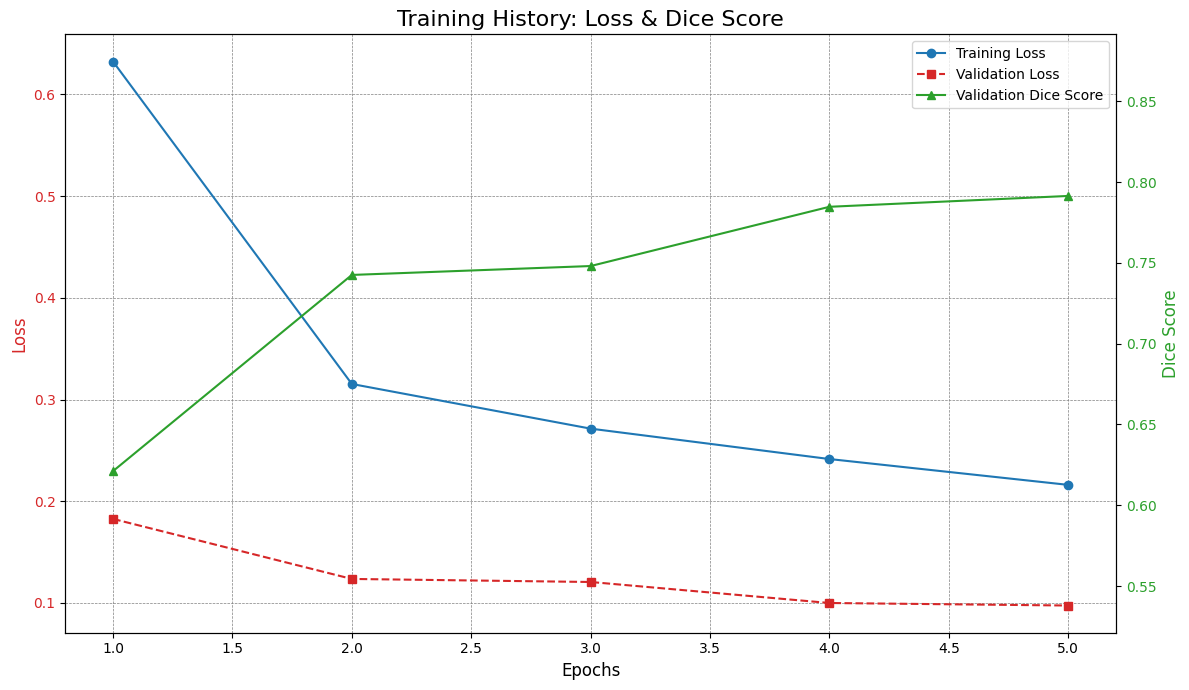

In [54]:
plot_training_history(history = history)

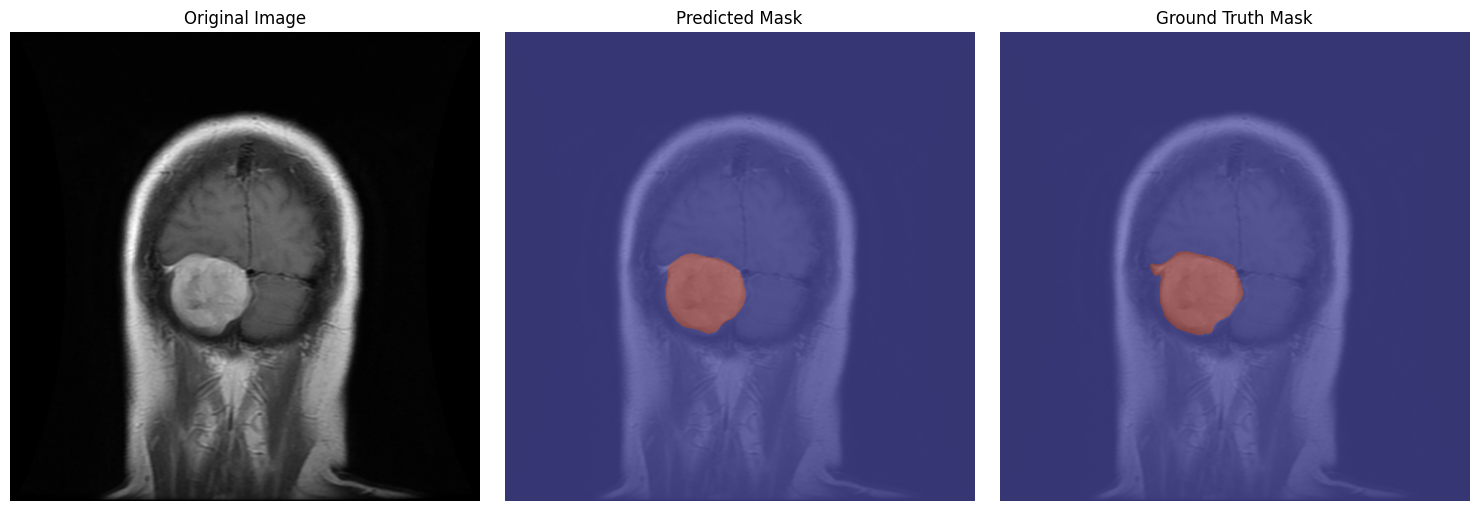

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(512, 512))

In [65]:
pic_number = random.randint(1, 3064)
IMAGE_PATH = f"brain_tumor_dataset/images/{pic_number}.png"
MASK_PATH = f"brain_tumor_dataset/masks/{pic_number}.png"

predict_and_visualize(
    model = model,
    image_path = IMAGE_PATH,
    mask_path = MASK_PATH,
)

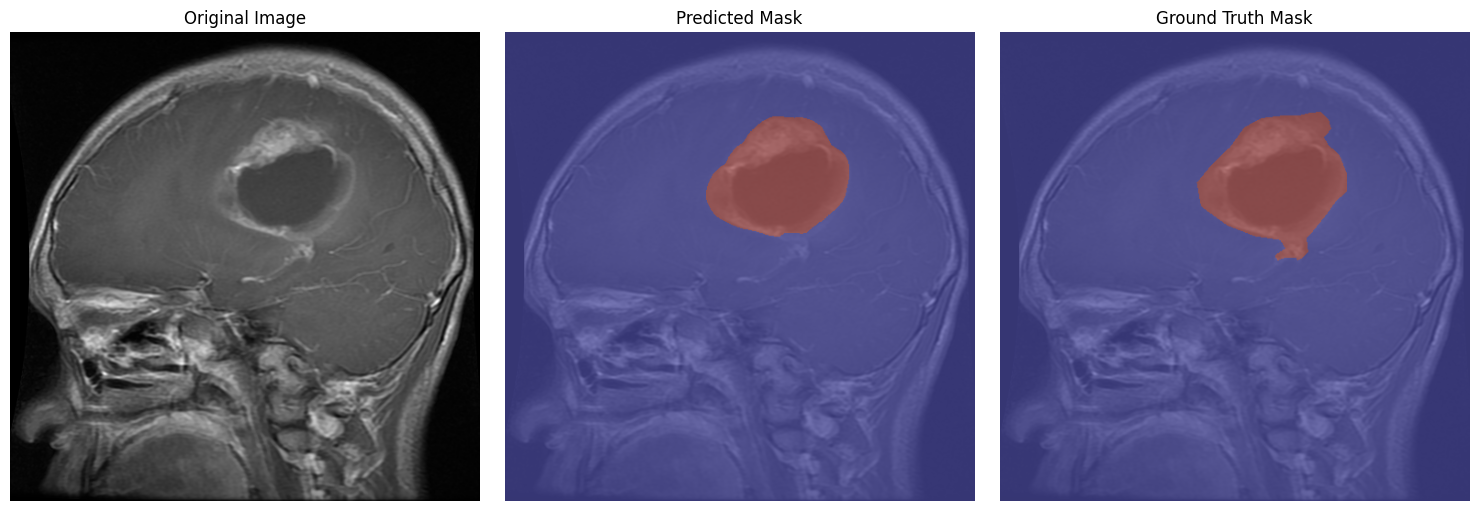

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(512, 512))

In [67]:
pic_number = random.randint(1, 3064)
IMAGE_PATH = f"brain_tumor_dataset/images/{pic_number}.png"
MASK_PATH = f"brain_tumor_dataset/masks/{pic_number}.png"

predict_and_visualize(
    model = model,
    image_path = IMAGE_PATH,
    mask_path = MASK_PATH,
)